#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# открытие файла, установка столбца datetime в качестве индекса и перевод в формат datetime
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
# ресемплируем временные интервал в 1 час
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


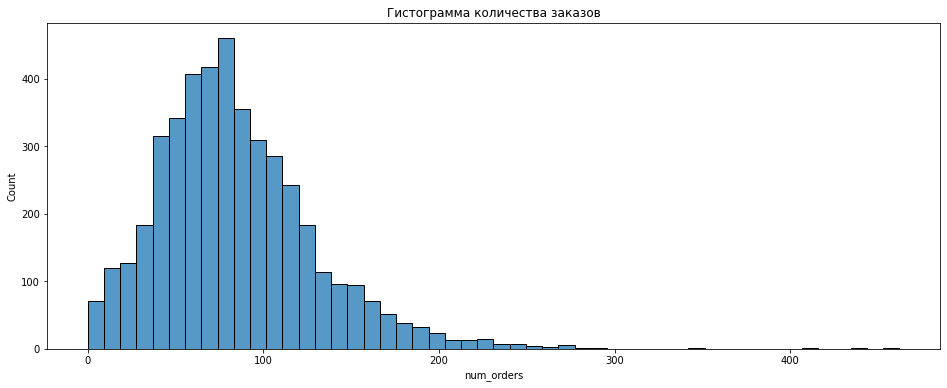

In [6]:
plt.figure(figsize=(16,6))
plt.title('Гистограмма количества заказов')
sns.histplot(data=df.num_orders, bins=50);

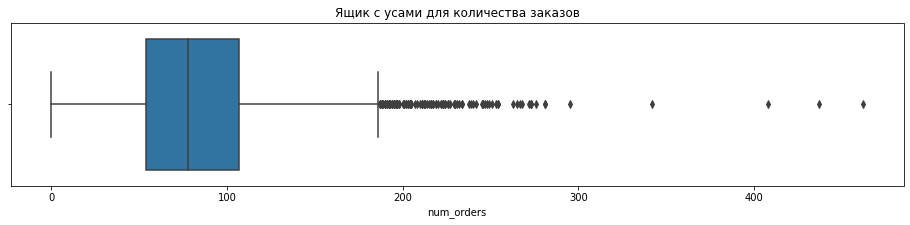

In [7]:
plt.figure(figsize=(16,3))
plt.title('Ящик с усами для количества заказов')
sns.boxplot(data=df, x='num_orders');

Выборка по количеству заказов подчиняется закону нормального распределения. Присутствует небольшое количество выбросов - нехарактерно большое количество заказов в выбранном интервале.

### Вывод

Данные изучены и произведено ресемплирование по 1 часу.

## Анализ

In [8]:
# проверка монотонности временного ряда
df.index.is_monotonic

True

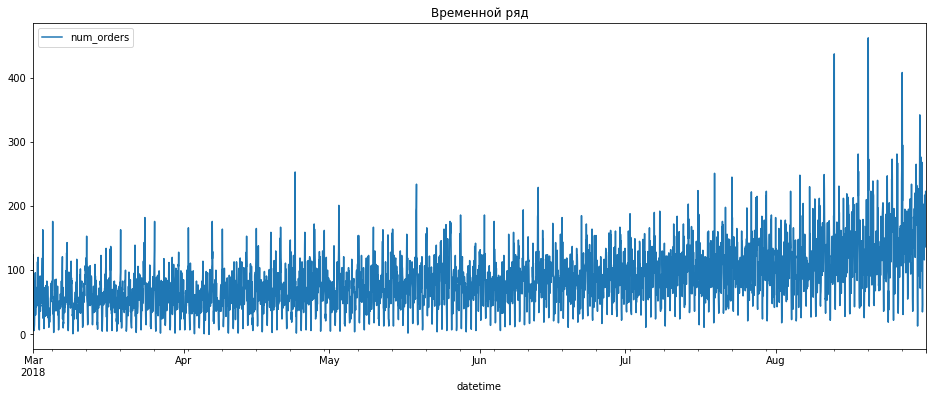

In [9]:
df.plot(figsize=(16,6), title='Временной ряд');

Произведём декомпозицию временного ряда на тренд, сезонности и остаток.

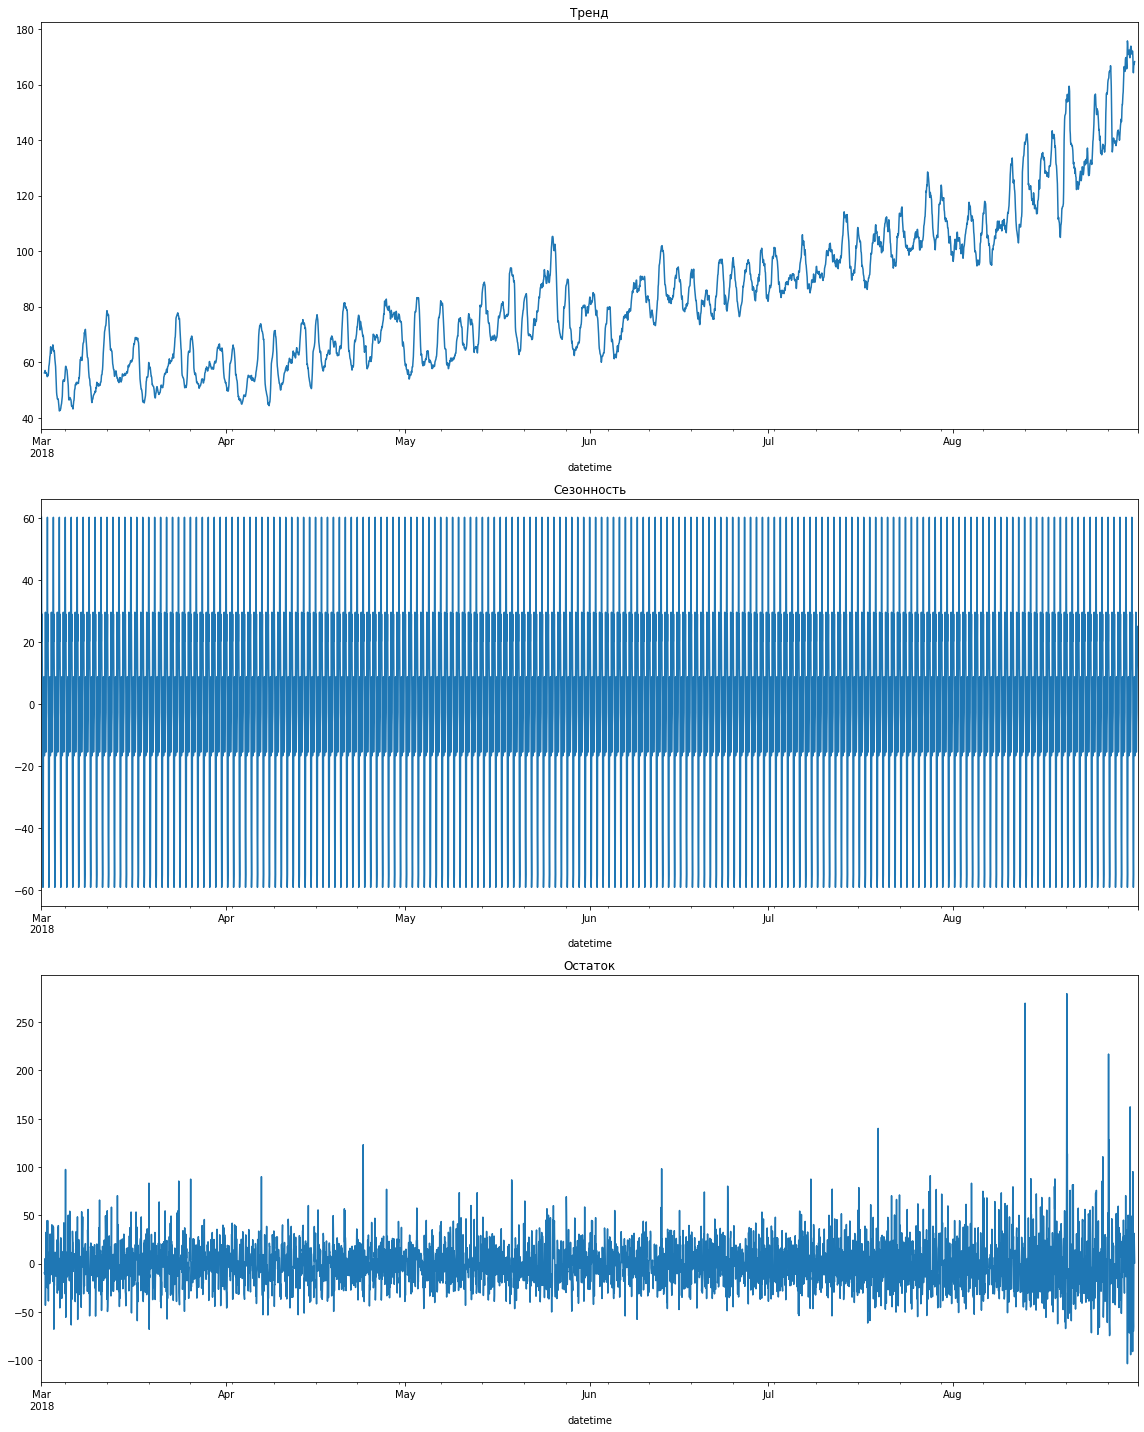

In [10]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

На графике тренда видим рост количества заказов в течение рассматриваемого интервала времени в 6 месяцев.

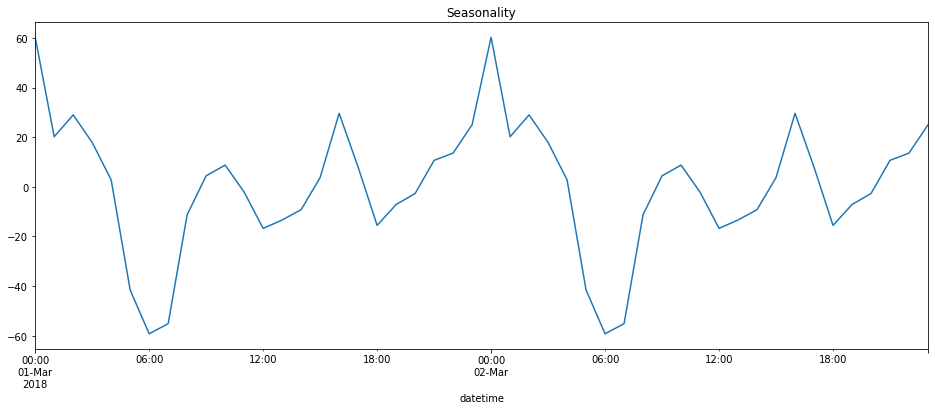

In [11]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(16, 6))
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality');

При рассмотрении сезонности в масштабах суток можно заметить характерные интервалы пикового роста и падения спроса на такси.

### Вывод

- На графике тренда видим рост количества заказов в течение рассматриваемого интервала времени в 6 месяцев. Вывод о причинах (связан ли рост заказов с сезоном отпусков или с ростом компании) можно было бы сделать при наличии данных за больший интервал времени. Тем не менее масштаб имеющихся данных позволяет обучать модели для прогнозирования заказов на следующий час.
- График сезонности показывает суточную периодичность. Максимальный спрос на такси наблюдается в районе 00:00 часов, а минимальный - в 06:00.

## Обучение

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    """Функция создания признаков для прогнозирования"""
#     data['year'] = data.index.year
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

# установим отставание равным 1 и скользящее среднее 24
make_features(df, 1, 24)

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


In [13]:
# разбивка данных на тренировочную и целевую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [14]:
# проверка
display(features_train.shape, features_test.shape)
display(target_train.shape, target_test.shape)

(3950, 4)

(442, 4)

(3950,)

(442,)

Для решения задачи прогнозирования рассмотрим модели:
- Решающее дерево
- Случайный лес
- Линейная регрессия
- CatBoost

а также сравним результаты работы моделей с результатами dummy модели.

In [15]:
tscv = TimeSeriesSplit(n_splits=23)

In [16]:
%%time
# подбор гиперпараметров для решающего дерева
parameters = { 'max_depth': range (1,20, 2) }
dtr = DecisionTreeRegressor(random_state=12345)
gsearch = GridSearchCV(dtr, parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(features_train, target_train)
predictions_tree = gsearch.predict(features_train)

display(gsearch.best_params_)
gsearch.best_score_

Fitting 23 folds for each of 10 candidates, totalling 230 fits


{'max_depth': 7}

CPU times: user 1.72 s, sys: 5.45 ms, total: 1.72 s
Wall time: 1.74 s


-26.901816218429683

In [17]:
# features_train

In [18]:
%%time
# подбор гиперпараметров для случайного леса
parameters = { 'n_estimators': (100, 200, 300, 400, 500),
              'max_depth': (1, 5, 10, 20) }
rfr = RandomForestRegressor(random_state=12345)
gsearch = GridSearchCV(rfr, parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(features_train, target_train)
predictions_valid = gsearch.predict(features_train)

display(gsearch.best_params_)
gsearch.best_score_

Fitting 23 folds for each of 20 candidates, totalling 460 fits


{'max_depth': 20, 'n_estimators': 300}

CPU times: user 6min 18s, sys: 2.96 s, total: 6min 21s
Wall time: 6min 22s


-23.23770578783538

In [19]:
def model_rmse(model, features, target):
    """функция обучения и определения RMSE моделей"""
    rmse = cross_val_score(model, features, target, cv=tscv, scoring='neg_root_mean_squared_error').mean()
    return print('RMSE модели {}:'.format(model), rmse)

In [20]:
%%time
# линейная регрессия
model_rmse(LinearRegression(), features_train, target_train)

RMSE модели LinearRegression(): -30.717188480272046
CPU times: user 96.3 ms, sys: 7.96 ms, total: 104 ms
Wall time: 103 ms


In [21]:
%%time
# CatBoost
model_rmse(CatBoostRegressor(random_state=12345), features_train, target_train)

Learning rate set to 0.031171
0:	learn: 30.0260858	total: 46.5ms	remaining: 46.4s
1:	learn: 29.7001486	total: 47ms	remaining: 23.4s
2:	learn: 29.3930189	total: 47.3ms	remaining: 15.7s
3:	learn: 29.0851173	total: 47.8ms	remaining: 11.9s
4:	learn: 28.7543078	total: 48.1ms	remaining: 9.57s
5:	learn: 28.4605369	total: 48.4ms	remaining: 8.02s
6:	learn: 28.2031576	total: 48.8ms	remaining: 6.92s
7:	learn: 27.9256191	total: 49.1ms	remaining: 6.09s
8:	learn: 27.6243735	total: 49.5ms	remaining: 5.45s
9:	learn: 27.3420973	total: 49.8ms	remaining: 4.93s
10:	learn: 27.1055989	total: 50.2ms	remaining: 4.51s
11:	learn: 26.8814356	total: 50.5ms	remaining: 4.16s
12:	learn: 26.6336643	total: 50.8ms	remaining: 3.86s
13:	learn: 26.4825497	total: 51.1ms	remaining: 3.6s
14:	learn: 26.2410328	total: 51.5ms	remaining: 3.38s
15:	learn: 26.0362314	total: 51.8ms	remaining: 3.18s
16:	learn: 25.7853906	total: 52.1ms	remaining: 3.01s
17:	learn: 25.5503125	total: 52.4ms	remaining: 2.86s
18:	learn: 25.3500657	total: 

In [22]:
# работа dummy модели
model_rmse(DummyRegressor(strategy='mean'), features_train, target_train)

RMSE модели DummyRegressor(): -38.25923506084101


In [23]:
model_train_dict = {'Model_name': ['DecisionTreeRegressor',
                             'RandomForestRegressor',
                             'LinearRegression',
                             'CatBoostRegressor',
                             'DummyRegressor'],
             'RMSE_train': [26.9, 23.24, 30.72, 23.04, 38.26]}
df_train_result = pd.DataFrame(model_train_dict)
df_train_result

,Model_name,RMSE_train
0,DecisionTreeRegressor,26.90
1,RandomForestRegressor,23.24
2,LinearRegression,30.72
3,CatBoostRegressor,23.04
4,DummyRegressor,38.26


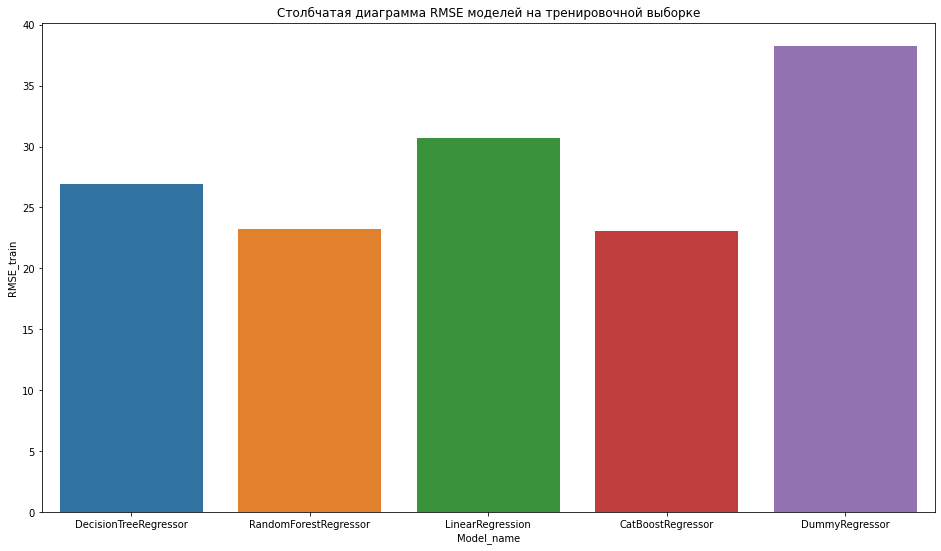

In [24]:
plt.figure(figsize=(16,9))
plt.title('Столбчатая диаграмма RMSE моделей на тренировочной выборке')
sns.barplot(x='Model_name', y='RMSE_train', data=df_train_result);

### Вывод

- На тренировочной выборке были обучены 4 модели: решающее дерево, случайный лес, линейная регрессия, CatBoost и подобраны оптимальные гиперпараметры.
- Лучший результат показала модель CatBoost. RMSE = 23,04.
- Все исследуемые модели прошли тест на адекватность, показав результат RMSE лучший, чем у dummy модели.

## Тестирование

**DecisionTree**

RMSE модели DecisionTreeRegressor: 50.86814241262326


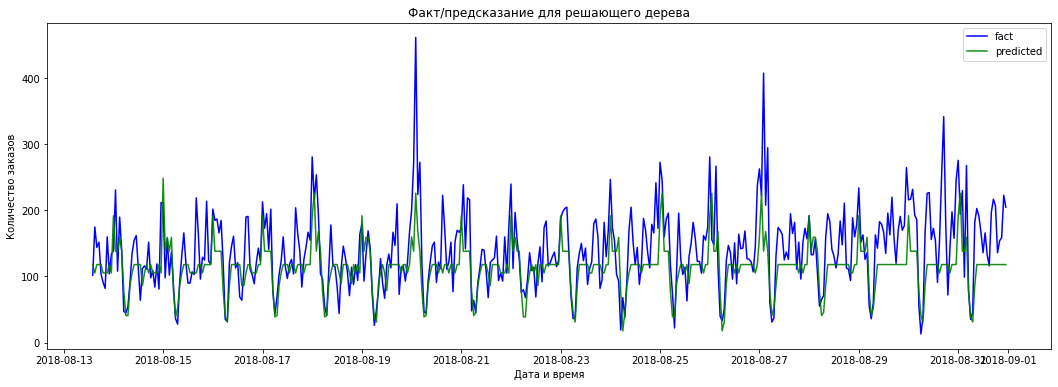

In [25]:
dtr = DecisionTreeRegressor(max_depth=7, random_state=12345)
predictions_dtr = dtr.fit(features_train, target_train).predict(features_test)
rmse = mean_squared_error(target_test, predictions_dtr) ** 0.5
print('RMSE модели DecisionTreeRegressor:', rmse)

plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для решающего дерева')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test.index, target_test, 'b-', label='fact')
plt.plot(target_test.index, predictions_dtr, 'g-', alpha=.9, label='predicted')
plt.legend();

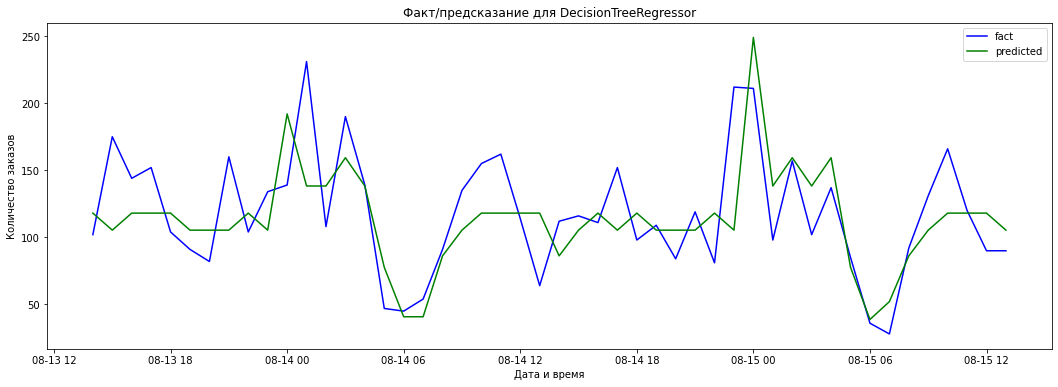

In [26]:
plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для DecisionTreeRegressor')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test[:48].index, target_test[:48], 'b-', label='fact')
plt.plot(target_test[:48].index, predictions_dtr[:48], 'g-', label='predicted')
plt.legend();

**RandomForest**

RMSE модели RandomForestRegressor: 47.16976873240259


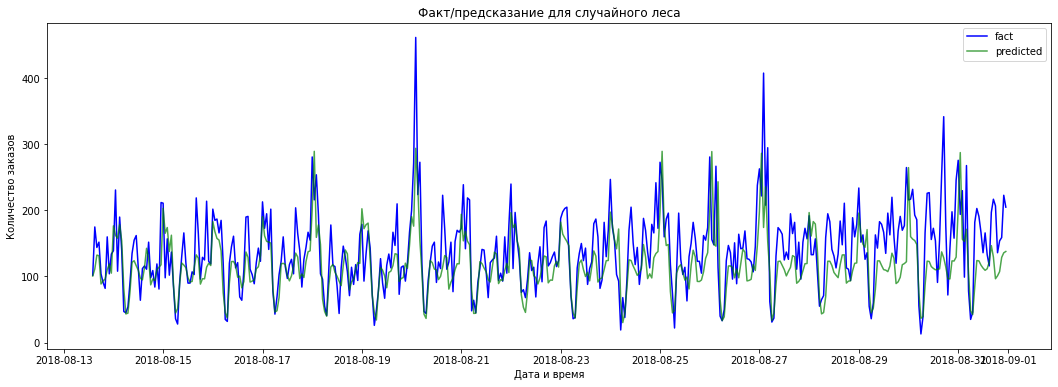

In [27]:
rfr = RandomForestRegressor(max_depth=10, n_estimators=400, random_state=12345)
predictions_rfr = rfr.fit(features_train, target_train).predict(features_test)
rmse = mean_squared_error(target_test, predictions_rfr) ** 0.5
print('RMSE модели RandomForestRegressor:', rmse)

plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для случайного леса')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test.index, target_test, 'b-', label='fact')
plt.plot(target_test.index, predictions_rfr, 'g-', alpha=.7, label='predicted')
plt.legend();

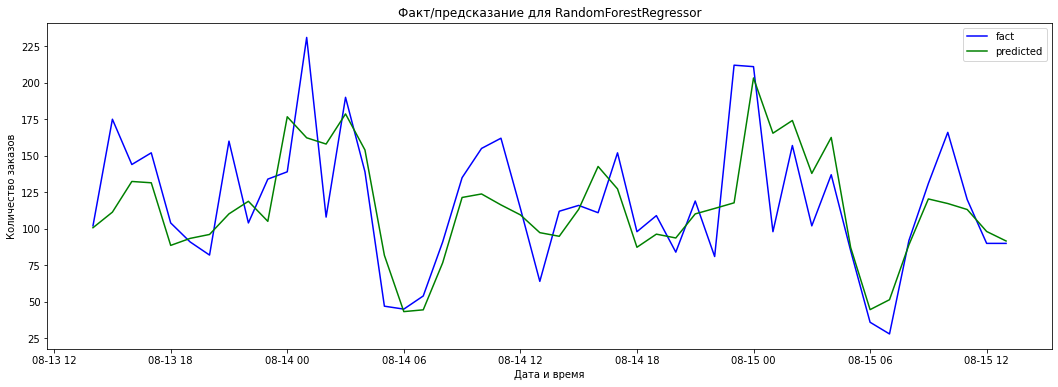

In [28]:
plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для RandomForestRegressor')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test[:48].index, target_test[:48], 'b-', label='fact')
plt.plot(target_test[:48].index, predictions_rfr[:48], 'g-', label='predicted')
plt.legend();

**LinearRegression**

RMSE модели LinearRegression: 51.19408067165248


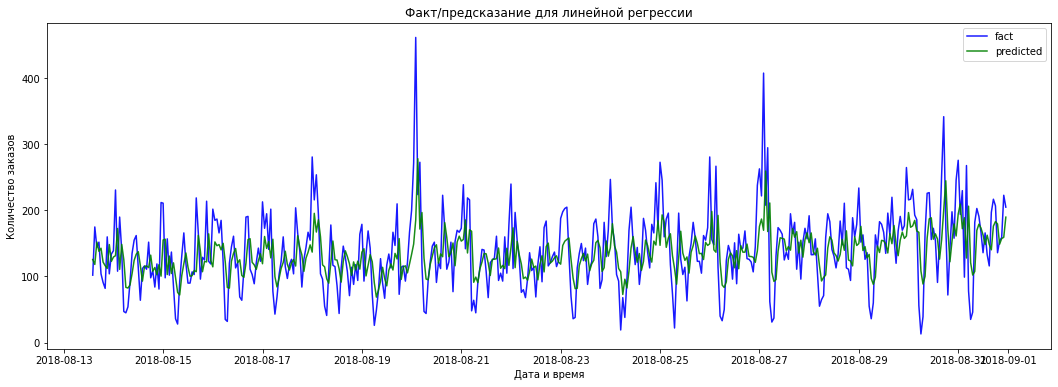

In [29]:
lr = LinearRegression()
predictions_lr = lr.fit(features_train, target_train).predict(features_test)
rmse = mean_squared_error(target_test, predictions_lr) ** 0.5
print('RMSE модели LinearRegression:', rmse)

plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для линейной регрессии')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test.index, target_test, 'b-', alpha=.9, label='fact')
plt.plot(target_test.index, predictions_lr, 'g-', alpha=.9, label='predicted')
plt.legend();

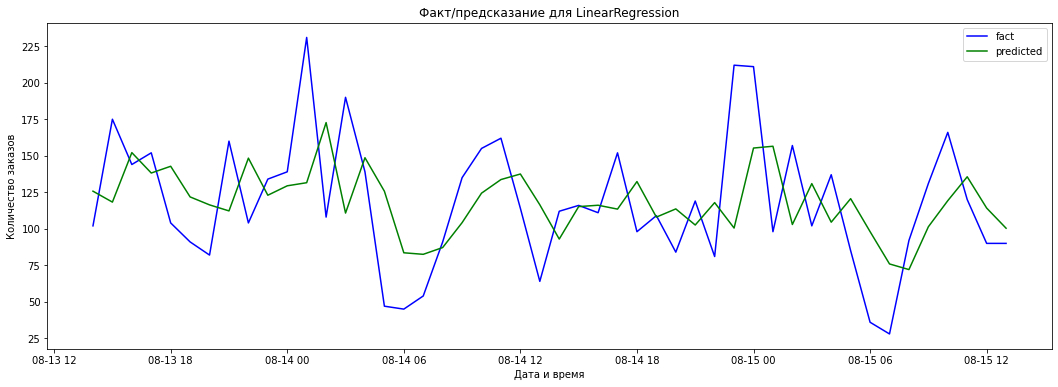

In [30]:
plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для LinearRegression')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test[:48].index, target_test[:48], 'b-', label='fact')
plt.plot(target_test[:48].index, predictions_lr[:48], 'g-', label='predicted')
plt.legend();

**CatBoost**

Learning rate set to 0.050868
0:	learn: 37.7740753	total: 1.17ms	remaining: 1.17s
1:	learn: 37.1258375	total: 2.33ms	remaining: 1.16s
2:	learn: 36.4535698	total: 3.38ms	remaining: 1.12s
3:	learn: 35.6677843	total: 4.43ms	remaining: 1.1s
4:	learn: 34.9561572	total: 5.46ms	remaining: 1.09s
5:	learn: 34.3186014	total: 6.47ms	remaining: 1.07s
6:	learn: 33.6479092	total: 7.43ms	remaining: 1.05s
7:	learn: 33.0217282	total: 8.64ms	remaining: 1.07s
8:	learn: 32.5377192	total: 9.63ms	remaining: 1.06s
9:	learn: 31.9680067	total: 10.8ms	remaining: 1.07s
10:	learn: 31.4077636	total: 11.9ms	remaining: 1.07s
11:	learn: 31.0030519	total: 12.8ms	remaining: 1.06s
12:	learn: 30.5927723	total: 13.9ms	remaining: 1.05s
13:	learn: 30.1555370	total: 14.8ms	remaining: 1.04s
14:	learn: 29.8418498	total: 15.8ms	remaining: 1.04s
15:	learn: 29.5141659	total: 16.8ms	remaining: 1.04s
16:	learn: 29.2098680	total: 18ms	remaining: 1.04s
17:	learn: 28.9286581	total: 19ms	remaining: 1.03s
18:	learn: 28.5906983	total: 19

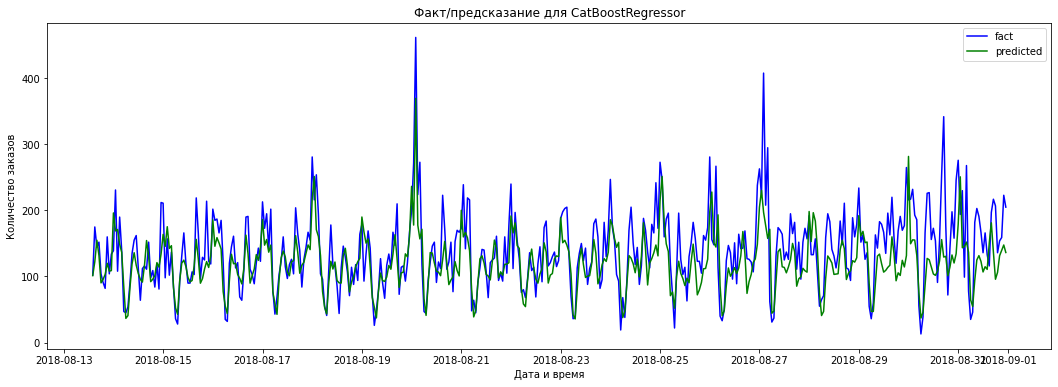

In [31]:
cbr = CatBoostRegressor(random_state=12345)
predictions_cbr = cbr.fit(features_train, target_train).predict(features_test)
rmse = mean_squared_error(target_test, predictions_cbr) ** 0.5
print('RMSE модели CatBoostRegressor:', rmse)

plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для CatBoostRegressor')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test.index, target_test, 'b-', label='fact')
plt.plot(target_test.index, predictions_cbr, 'g-', label='predicted')
plt.legend();

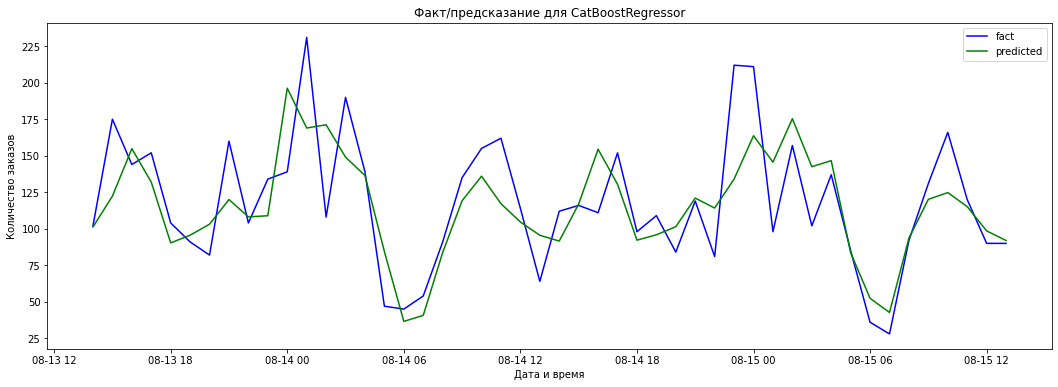

In [32]:
plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для CatBoostRegressor')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test[:48].index, target_test[:48], 'b-', label='fact')
plt.plot(target_test[:48].index, predictions_cbr[:48], 'g-', label='predicted')
plt.legend();

**Dummy model**

RMSE модели DummyRegressor: 84.6499381993622


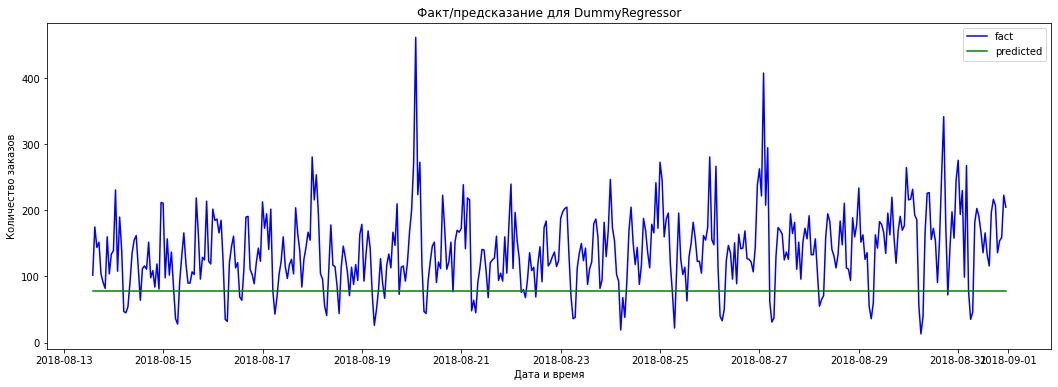

In [33]:
dummy = DummyRegressor(strategy='mean')
predictions_dummy = dummy.fit(features_train, target_train).predict(features_test)
rmse = mean_squared_error(target_test, predictions_dummy) ** 0.5
print('RMSE модели DummyRegressor:', rmse)

plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для DummyRegressor')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test.index, target_test, 'b-', label='fact')
plt.plot(target_test.index, predictions_dummy, 'g-', label='predicted')
plt.legend();

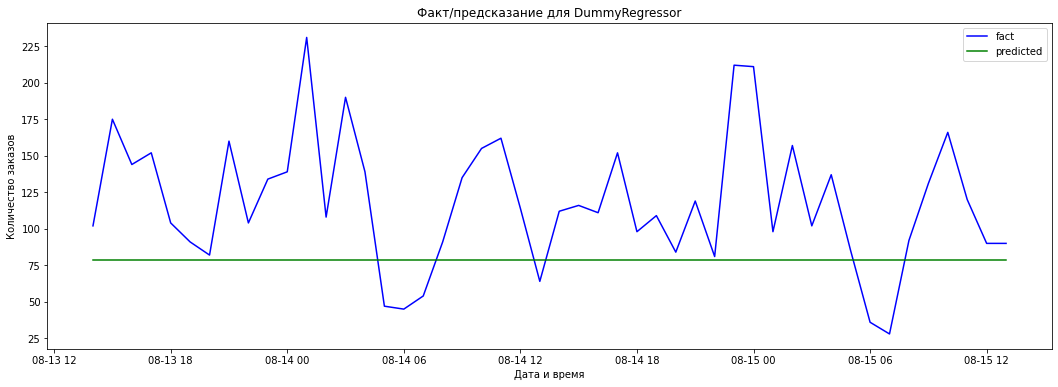

In [34]:
plt.figure(figsize=(18,6))
plt.title('Факт/предсказание для DummyRegressor')
plt.xlabel('Дата и время', color='black')
plt.ylabel('Количество заказов',color='black')
plt.plot(target_test[:48].index, target_test[:48], 'b-', label='fact')
plt.plot(target_test[:48].index, predictions_dummy[:48], 'g-', label='predicted')
plt.legend();

In [35]:
model_test_dict = {'Model_name': ['DecisionTreeRegressor',
                             'RandomForestRegressor',
                             'LinearRegression',
                             'CatBoostRegressor',
                             'DummyRegressor'],
             'RMSE_test': [50.87, 47.17, 51.19, 43.7, 84.65]}
df_test_result = pd.DataFrame(model_test_dict)
df_test_result

,Model_name,RMSE_test
0,DecisionTreeRegressor,50.87
1,RandomForestRegressor,47.17
2,LinearRegression,51.19
3,CatBoostRegressor,43.70
4,DummyRegressor,84.65


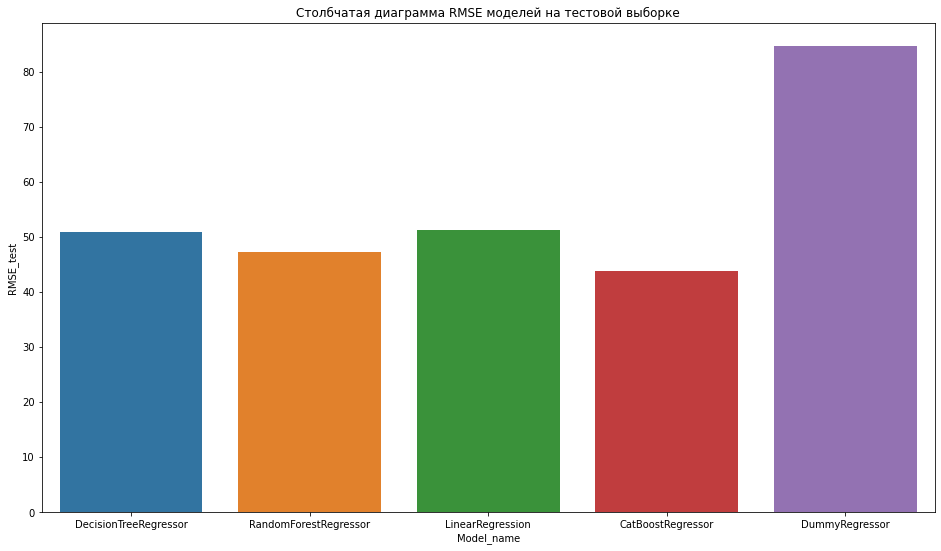

In [36]:
plt.figure(figsize=(16,9))
plt.title('Столбчатая диаграмма RMSE моделей на тестовой выборке')
sns.barplot(x='Model_name', y='RMSE_test', data=df_test_result);

In [37]:
df_result_merged = df_train_result.merge(df_test_result, on='Model_name')
df_result_merged = df_result_merged.set_index('Model_name')
df_result_merged

,RMSE_train,RMSE_test
Model_name,,
DecisionTreeRegressor,26.90,50.87
RandomForestRegressor,23.24,47.17
LinearRegression,30.72,51.19
CatBoostRegressor,23.04,43.70
DummyRegressor,38.26,84.65


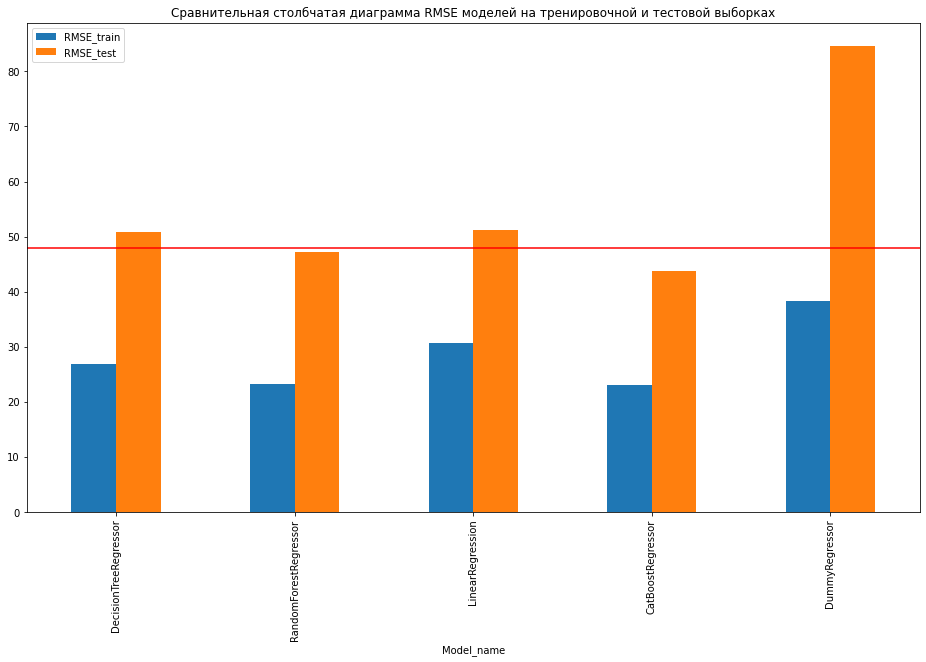

In [38]:
plt.subplot(111)
df_result_merged.plot(kind='bar',
                      figsize=(16,9),
                      title='Сравнительная столбчатая диаграмма RMSE моделей на тренировочной и тестовой выборках',
                      ax=plt.gca()).hlines(48, -1, 5, color='red'); # граница метрики RMSE на тестовой выборке 48

### Вывод

- **По итогам работы и тестирования моделей лучшей стала CatBoost с RMSE = 43,7, что также подтверждается при рассмотрении сравнительного графика факт/предсказание в масштабе.**
- Кроме того, приемлемое качество, выполнив условие RMSE < 48, показала модель RandomForest.

Небольшой размер тестовой выборки а также увеличение дисперсии в августе, которое можно видеть на графике шума, полученном при декомпоиции ряда, повлияло на качество работы моделей.